In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
sys.path.insert(0, '/home/jovyan/mne-python/')
import pickle
import warnings
warnings.filterwarnings("ignore", message="y_pred contains classes not")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, balanced_accuracy_score

from braindecode.datasets.tuh import TUHAbnormal
from braindecode.preprocessing import create_fixed_length_windows, preprocess

from decode_tueg import (
    get_preprocessors,
    DataScaler, TargetScaler, trial_age_mae, Augmenter, ChannelsSymmetryFB,
    get_datasets, test_name, create_windows, create_final_scores,
    plot_chronological_vs_predicted_age, plot_age_gap_hist,
    plot_thresh_to_acc, plot_joint_scatter, plot_learning, save_fig,
    load_exp, predict_ds, plot_heatmaps, plot_heatmap
)

In [3]:
base_dir = '/home/jovyan/new_full_runs/'
# base_dir = '/home/jovyan/outdated_runs/'
# base_dir = '/home/jovyan/full_runs/'
exps = {
    'huber': {
         0: '220824144055632350',
         1: '220824191628058941',
         2: '220824144128724203',
         3: '220824144139015381',
         4: '220824144141880751',
    },
    'mse': {
        0: '220825094141505678',
        1: '220825094133879370',
        2: '220825094140973211',
        3: '220825094139201071',
        4: '220825141741077814',
        
    },
    'mae': {
        0: '220826151546978486',
         1: '220826104417444602',
         2: '220826104408477306',
         3: '220826104426911900',
         4: '220826104430495864',
    },
    'nll': {
        0: '220831200810717294',
    },
    # old results
#     'huber': {
#         0: '220824144254199487',
#     },
#     'nll': {
#         0: '220725141944002603'
#     },
}
# seeds = []  #  TODO: run multiple seeds
model = 'train_end'  # 'train_end', 'valid_best'
n_jobs = 6

In [4]:
only_valid = True
subsets = ['mixed']#, 'mixed', 'abnormal']
mem_efficient = True
exp_style = 'huber'

In [5]:
# hardcoded to enable order in code below
window_size_samples = 6000
window_stride_samples = 496

In [ ]:
for longitudinal in ['transition', 'non_pathological', 'pathological']:
    print('longitudinal', longitudinal)
#     out_dir = os.path.join(base_dir, exp)
    with open(f'/home/jovyan/longitudinal/{longitudinal}.pkl', 'rb') as f:
        ds = pickle.load(f)
    
#     ds = ds.split(list(range(10)))['0']
    print(f'n={len(ds.datasets)}')

    print('preprocess')
    preprocessors = get_preprocessors(59, tmax=None)
    ds = preprocess(ds, preprocessors=preprocessors, n_jobs=n_jobs)
    
    print('create windows')
    ds = create_fixed_length_windows(
        ds,
        window_size_samples=window_size_samples,
        window_stride_samples=window_stride_samples,
        n_jobs=min(n_jobs, 4),
        preload=False,
        mapping=None,
        drop_last_window=False,
        drop_bad_windows=True,
        reject=None,
        flat=None,
    )
    
    dfs = []
    for exp_i, exp in exps[exp_style].items():
        print('exp', exp)
        clf, data_scaler, target_scaler, config = load_exp(base_dir, exp, model)
        if isinstance(data_scaler, list):
            data_scaler = data_scaler[0]  # TODO: fix this
        
        print('predicting')
        preds, targets = predict_ds(
            clf,
            ds, 
            'age',
            target_scaler,
            data_scaler,
            n_jobs,
            mem_efficient=mem_efficient,
            trialwise=True,
            average_time_axis=True,
        )
        if config.target_name in ['age']:
            score = mean_absolute_error(targets, preds)
        else:
            score = balanced_accuracy_score(targets, preds)

        # TODO: add subject
        df = pd.DataFrame({
            'y_pred': preds.ravel(),
            'y_true': targets.ravel(),
            'pathological': ds.description['pathological'].to_numpy() == 1,
            'exp': len(ds.description) * [exp],
#             'subset': len(ds.description) * [subset],
            'split': len(ds.description) * [longitudinal],
            'fold': len(ds.description) * [exp_i],
        })
        dfs.append(df)
    dfs = pd.concat(dfs, ignore_index=True)
    dfs.to_csv(f'/home/jovyan/220824_5fcv_{exp_style}_longitudinal_{longitudinal}.csv')

longitudinal transition
n=3357
preprocess
2022-09-07 20:00:13 DEBUG    adding cropper 59 – None
create windows
exp 220824144055632350
predicting
exp 220824191628058941
predicting
exp 220824144128724203
predicting
exp 220824144139015381
predicting
exp 220824144141880751
predicting
longitudinal non_pathological
n=4068
preprocess
2022-09-07 22:04:23 DEBUG    adding cropper 59 – None
create windows
exp 220824144055632350
predicting
exp 220824191628058941
predicting
exp 220824144128724203
predicting
exp 220824144139015381
predicting
exp 220824144141880751
predicting
longitudinal pathological
n=18338
preprocess
2022-09-08 00:26:38 DEBUG    adding cropper 59 – None
create windows
exp 220824144055632350
predicting
exp 220824191628058941
predicting
exp 220824144128724203
predicting
exp 220824144139015381
predicting


In [16]:
subject_wise = False
bin_size = 3
max_age = 100

41.66515731573105

In [33]:
subject_wise=True
bin_size=3
max_age=100
hist_max_count=100#2200

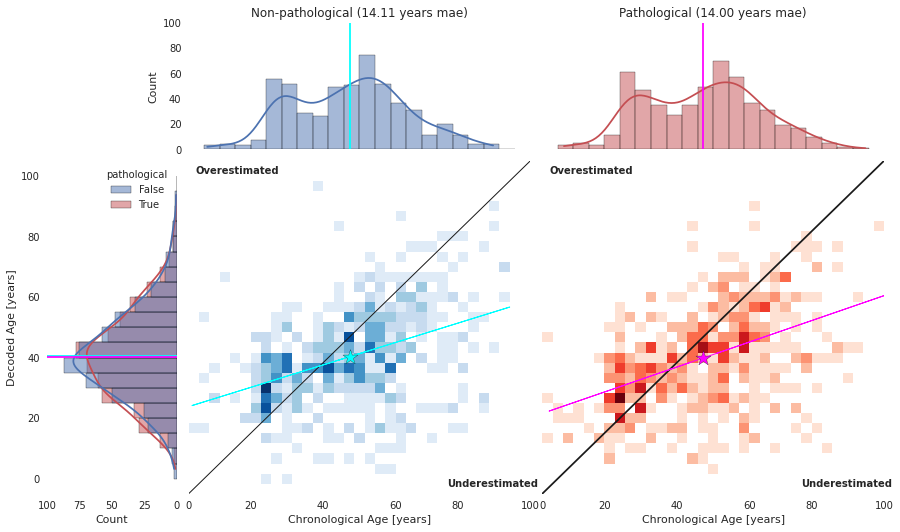

In [34]:
# fdescribe i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
longitudinal = 'transition'
df = pd.read_csv(f'/home/jovyan/220824_5fcv_huber_longitudinal_{longitudinal}.csv', index_col=0)
# --- hack
with open(f'/home/jovyan/longitudinal/{longitudinal}.pkl', 'rb') as f:
    ds = pickle.load(f)
df['subject'] = 5*ds.description['subject'].to_list()
# ---
if subject_wise:
    df = df.groupby(['subject', 'pathological'], as_index=False).mean()

ax_arr = plot_heatmaps(df, bin_size, max_age, hist_max_count)
# ax_arr.get_figure().savefig(os.path.join(f'/home/jovyan/longitudinal-{longitudinal}_chronological_vs_predicted_age.png'), 
#                             dpi=300, bbox_inches='tight')

hi


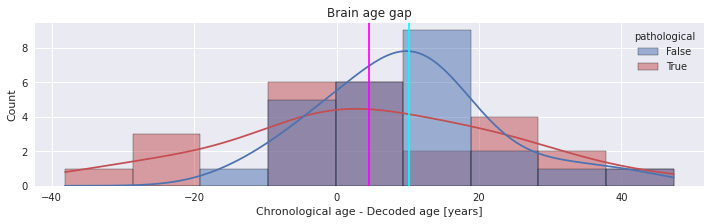

In [26]:
# for i, longitudinal in enumerate(['transition', 'non_pathological', 'pathological']):
df = pd.read_csv(f'/home/jovyan/220824_5fcv_huber_longitudinal_{longitudinal}.csv', index_col=0)
# --- hack
with open(f'/home/jovyan/longitudinal/{longitudinal}.pkl', 'rb') as f:
    ds = pickle.load(f)
df['subject'] = 5*ds.description['subject'].to_list()
# ---
if subject_wise:
    df = df.groupby(['subject', 'pathological'], as_index=False).mean()

ax = plot_age_gap_hist(df)
#save_fig(ax.get_figure(), out_dir, f'longitudinal-{longitudinal}_chronological_vs_predicted_age')

preprocess and window longitudinal datasets and save afterwards

In [1]:
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')

In [2]:
import os

In [3]:
import pickle

In [4]:
from decode_tueg import (
    get_longitudinal_ds, preprocess, get_preprocessors,
    _create_windows, _create_final_scores, load_exp,
    get_n_preds_per_input
)

In [5]:
exp_date = '2023-02-01T12:05:20.040919'

In [6]:
exp_dir = '/home/jovyan/experiments/'

In [7]:
mapping = None  # where to get this from?
pred_path = '/home/jovyan/'
checkpoint = 'train_end'

In [8]:
seed = str(20230201)
run = str(0)

In [9]:
estimator, data_scaler, target_scaler, config = load_exp(
    exp_dir, os.path.join(exp_date, seed, run), checkpoint)

In [10]:
min_age = int(config.min_age)
max_age = int(config.max_age)
tmin = -1#int(config.tmin)
tmax = -1#int(config.tmax)
n_jobs = int(config.n_jobs)
window_size_samples = int(config.window_size_samples)
preload = int(config.preload)
target_name = config.target_name
out_dir = config.out_dir

predict the longitudinal datasets

In [1]:
import os
import sys
sys.path.insert(0, '/home/jovyan/braindecode/')
import pickle

In [2]:
import numpy as np
import pandas as pd

In [3]:
from decode_tueg import (
    deconfound, load_exp, _create_final_scores, plot_age_gap_hist, plot_heatmaps,
    save_csv, plot_age_gap_hist_and_permutation_test,
)

In [4]:
exp_date = '2023-02-01T14:42:53.219167'
checkpoint = 'train_end'

In [5]:
exp_dir = '/home/jovyan/experiments/'

In [6]:
n_recordings = None

In [7]:
all_ds_preds = {}
for ds_name in ['transition']: #['pathological', 'non_pathological', 'transition']:  # have this outer loop?
    seeds = sorted(os.listdir(os.path.join(exp_dir, exp_date)))
    for seed in seeds:
        runs = sorted(os.listdir(os.path.join(exp_dir, exp_date, seed)))
        for run_i, run in enumerate(runs):
            if run_i != 1:
                continue
            exp_path = os.path.join(exp_date, seed, run)
            print(f'loading exp {exp_path}')
            estimator, data_scaler, target_scaler, config = load_exp(
                exp_dir, exp_path, checkpoint)
            print(f'getting {ds_name}')
            with open(f'/home/jovyan/longitudinal/{ds_name}_pre_win.pkl', 'rb') as f:
                ds = pickle.load(f)
            if n_recordings not in [-1, None]:
                ds = ds.split(list(range(n_recordings)))['0']
            print('predicting')
            ds_preds, ds_score = _create_final_scores(
                estimator,
                ds,
                ds_name,
                config.target_name,
                target_scaler,
                data_scaler,
                int(config.n_jobs),
            )
            # write preds to file
            save_csv(
                ds_preds,
                os.path.join(exp_dir, exp_path, 'preds'),
                f'{checkpoint}_{ds_name}_preds.csv',
            )
            # write scores to file
            scores = pd.read_csv(
                os.path.join(os.path.join(exp_dir, exp_path), f'{checkpoint}_scores.csv'), 
                index_col=0,
            )
            scores = pd.concat([scores, ds_score])
            save_csv(
                ds_score,
                os.path.join(exp_dir, exp_path),
                f'{checkpoint}_scores.csv',
            )
            ds_preds['run'] = run_i
            ds_preds['seed'] = seed
            all_ds_preds[run_i] = ds_preds
        break  # only one seed for now
    break  # only one longitudinal ds for now

loading exp 2023-02-01T14:42:53.219167/20230201/1
getting transition
predicting
2023-02-02 15:34:25 INFO     on transition reached
2023-02-02 15:56:56 INFO     11.65 mae
2023-02-02 15:56:56 INFO     9.79 mdae
2023-02-02 15:56:56 INFO     0.34 r2
2023-02-02 15:56:56 INFO     0.41 mape
2023-02-02 15:56:56 INFO     0.20 mdape


In [8]:
if int(config.final_eval) == 0:
    # in cv append all predictions
    preds = pd.concat(all_ds_preds, ignore_index=True)
else:
    # in fe average all predictions
    # TODO: make sure not averaing wrong stuff
    raise NotImplementedError
    all_targets = [df.y_true for df_i, df in all_ds_preds.items()]
    # average preds and write back
    all_preds = [df.y_pred for df_i, df in all_ds_preds.items()]
    preds = all_ds_preds[0]
    preds['y_pred'] = np.mean(all_preds, axis=0)

In [9]:
bin_width = 2
n_repetitions = 10000  # actually 100000!
max_age = 100
detrend = 'quadratic'

<AxesSubplot: xlabel=' ', ylabel='Count'>

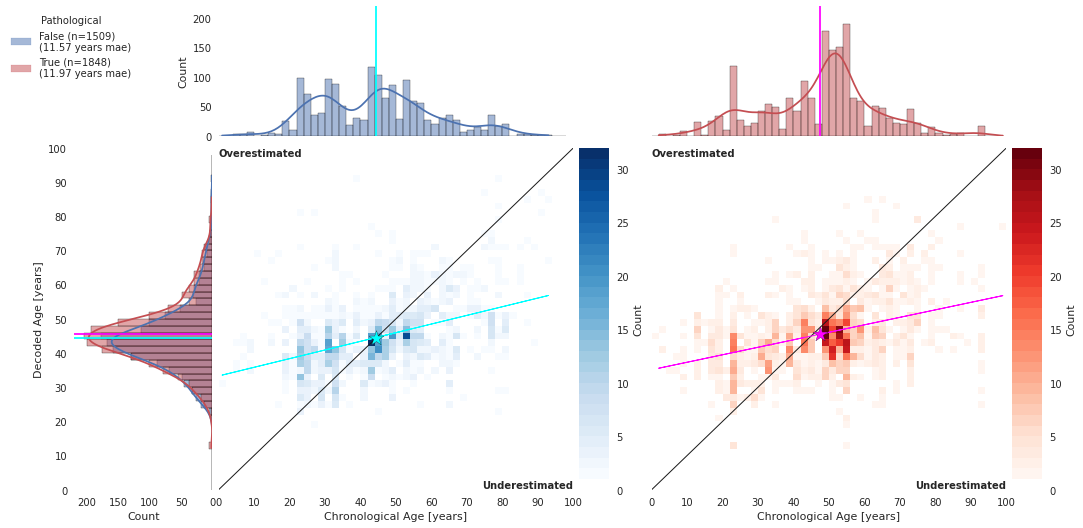

In [10]:
plot_heatmaps(preds, bin_width, max_age, hist_max_count=220)

In [11]:
# TODO: observed not diff of means. why?

observed age gap diff 0.3420536999190569


<AxesSubplot: xlabel='Decoded Age – Chronological Age [years]', ylabel='Count'>

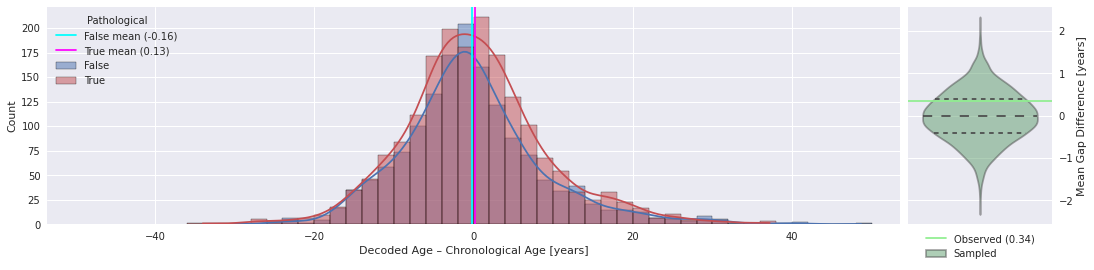

In [12]:
plot_age_gap_hist_and_permutation_test(deconfound(preds, detrend), bin_width, n_repetitions)

In [15]:
from decode_tueg import reject_derivating_ages

In [16]:
for ds_i, ds_ in enumerate(ds.datasets):
    break

In [18]:
_ = [ds_.set_description(
    {'path': ds_.description['path'].replace(
        '/data/datasets/TUH/EEG/tuh_eeg', '/home/jovyan/mne_data/TUH/tuh_eeg/')},
    overwrite=True,
) for ds_i, ds_ in enumerate(ds.datasets)]